# Optimisation Bayesienne 

#### 1. Généralisation de réalisations de processus stochastique 1D

In [2]:
# Importation des librairies nécessaires
%matplotlib inline
import numpy as np
import numpy.linalg as LA
from numpy.random import multivariate_normal
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.linalg import sqrtm
from scipy.optimize import minimize
from scipy.stats import norm
from pyDOE import lhs
from ipywidgets import interact, interactive, fixed, interact_manual,widgets
from IPython.display import display_javascript,HTML,Video
import os
import sys
import feuDeForet as fdf
import trieste
import tensorflow as tf
import gpflow
import tensorflow_probability as tfp
from trieste.models.gpflow.models import GaussianProcessRegression
from trieste.data import Dataset
from trieste.acquisition.rule import EfficientGlobalOptimization

2022-01-20 09:19:06.642093: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-20 09:19:06.642121: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-01-20 09:19:09.262551: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-20 09:19:09.262575: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-20 09:19:09.262593: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (enzo-XPS-13-9305): /proc/driver/nvidia/version does not exist
2022-01-20 09:19:09.263135: I tensorflow/core/platform/cpu_f

In [3]:
# Fonctions de covariances de processus gaussiens
# Le décorateur @np.vectorize sert à ce qu'on puisse utiliser les fonctions sur des vecteurs

@np.vectorize
def kg(x1,x2,theta=0.2,sigma=1):
    """
    Noyau de covariance gaussien
    """
    return sigma**2*np.exp(-(LA.norm(x1-x2)/theta)**2)

@np.vectorize
def ke(x1,x2,theta=0.2,sigma=1):
    """
    Noyau de covariance exponentiel
    """
    return sigma**2*np.exp(-LA.norm(x1-x2)/theta)

@np.vectorize
def kb(x1,x2):
    """
    Noyau de covariance d'un mouvement brownien (ne fonctionne qu'en 1D)
    """
    return min(x1,x2)



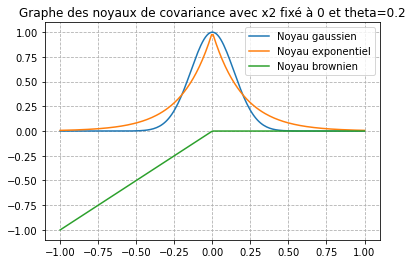

In [4]:
x1 = np.linspace(-1,1,200)
x2 = 0
theta=0.2
plt.title(f"Graphe des noyaux de covariance avec x2 fixé à {x2} et theta={theta}")
plt.plot(x1,kg(x1,x2,theta),label="Noyau gaussien")
plt.plot(x1,ke(x1,x2,theta),label="Noyau exponentiel")
plt.plot(x1,kb(x1,x2),label="Noyau brownien")
plt.legend()
plt.grid(ls="--")
plt.show()

In [5]:
np.random.seed(0)
def plot_gaussian_process(sigma,theta):
    n2=100
    x = np.linspace(0,1,n2)
    Kg = np.array([[kg(xi,xj,theta,sigma) for xi in x] for xj in x])
    Ke = np.array([[ke(xi,xj,theta,sigma) for xi in x] for xj in x])
    Z = multivariate_normal(np.zeros((n2,)),np.eye(n2,n2))
    Yg = np.real(sqrtm(Kg))@Z
    Ye = np.real(sqrtm(Ke))@Z
    plt.title("Graphe de réalisations de processus gaussiens avec les noyaux gaussien et exponentiel")
    plt.plot(x,np.array([Yg,Ye]).T)
    plt.legend(["Noyau Gaussien","Noyau exponentiel"])
    plt.grid(ls="--")
    plt.show()

interact(plot_gaussian_process,theta=(0.05,0.50,0.05),sigma=(1,10))
plt.show()
print()

interactive(children=(IntSlider(value=5, description='sigma', max=10, min=1), FloatSlider(value=0.25, descript…

$θ$ influe sur à quel point le processus varie et $σ$ influe sur l'amplitude des variations.

#### 2. Métamodélisation

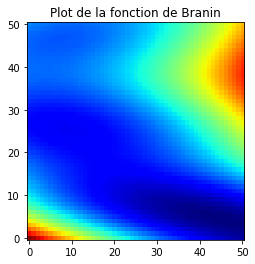

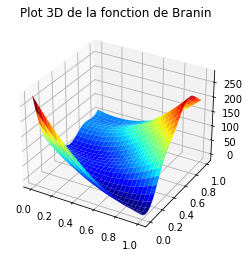

In [6]:
def fb(x):
    """
    Fonction de Branin avec les variables normalisées
    """
    pi = np.pi
    x1,x2 = x
    x1 = 15*x1-5
    x2 = 15*x2
    return (x2-5.1/(4*pi**2)*x1**2+5/pi*x1-6)**2+10*((1-1/(8*pi))*np.cos(x1)+1)+5*x1

N=51
x1 = np.linspace(0,1,N)
x2 = np.linspace(0,1,N)

def eval_func(x1,x2,f):
    X1,X2 = np.meshgrid(x1,x2)
    Z = np.zeros(X1.shape)
    for i,xi in enumerate(x1):
        for j,xj in enumerate(x2):
            Z[i,j]=f([xi,xj])
    return X1,X2,Z
X1,X2,Z = eval_func(x1,x2,fb)
plt.title("Plot de la fonction de Branin")
plt.imshow(Z,cmap=cm.jet,origin="lower")
plt.show()
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.set_title("Plot 3D de la fonction de Branin")
ax.plot_surface(X1,X2,Z,cmap=cm.jet)
plt.show()



On définit les fonctions pour le krigeage:

Elle résolvent le système $K_nλ =k_n$ et donnent comme résultat de l'interpolation $m_n = \sum_i λ_i y_i = λ^Ty$

In [7]:
if type(kg)==type(np.vectorize(lambda x:x)):
    kg = kg.pyfunc

def r(X1,X2,k_func=kg):
    if type(X1)==list:
        X1 = np.array(X1).reshape(1,-1)
    if type(X2)==list:
        X2 = np.array(X2).reshape(1,-1)
    R = np.zeros((X1.shape[0],X2.shape[0]))
    for i,xi in enumerate(X1):
        for j,xj in enumerate(X2):
            R[i,j] = k_func(xi,xj)
    return R

def y_func(X):
    y = np.zeros((len(X),1))
    for i,xi in enumerate(X):
        y[i] = fb(xi)
    return y

def mn(x,X,y,k_func=kg):
    r_vec = r(x,X,k_func)
    R_mat = r(X,X,k_func)
    return r_vec@(np.linalg.solve(R_mat,y))

def sigman2(Xn,y,k_func=kg):
    R_mat = r(Xn,Xn,k_func)
    n = R_mat.shape[0]
    return 1/n*y.T@(LA.solve(R_mat,y))

def vn(x,X,y,k_func=kg):
    r_vec = r(x,X,k_func=k_func).T
    sigma2 = sigman2(X,y,k_func=k_func)
    Rn = r(X,X,k_func=k_func)
    c = np.sum(r_vec*(LA.solve(Rn,r_vec)),axis=0)
    return sigma2*(1-c)


On essaie avec une grille uniforme

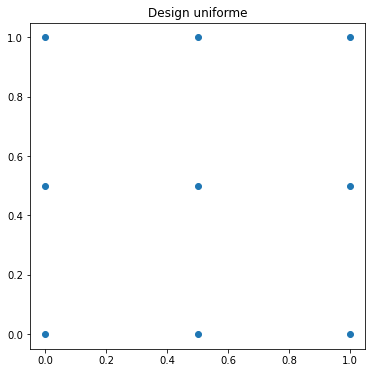

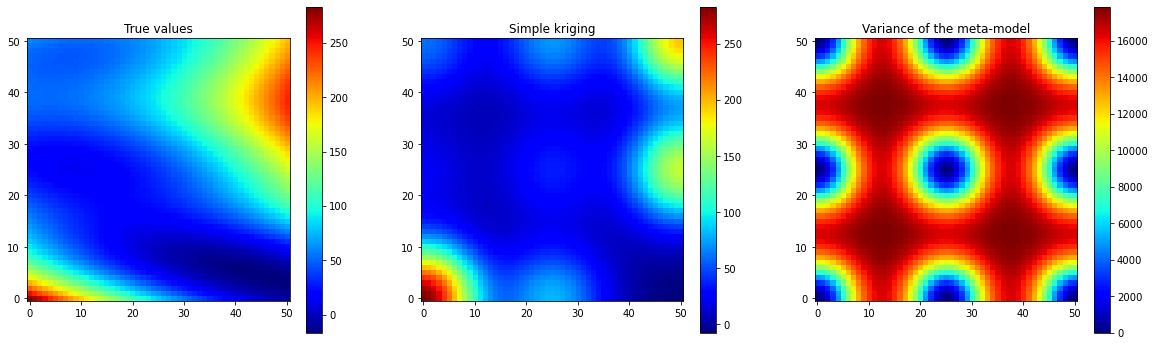

Erreur en norme L2 entre Z_true et Z: 2494.611526682984


In [8]:
x_uni = np.linspace(0,1,num=3)
X_uni = np.array([[xi,xj] for xi in x_uni for xj in x_uni])
y = y_func(X_uni)
plt.figure(figsize=(6,6))
plt.scatter(X_uni[:,0],X_uni[:,1])
plt.title("Design uniforme")
plt.show()
n_test = 51
x_test = np.linspace(0,1,n_test)
X_test = np.array([[xi,xj] for xi in x_test for xj in x_test])
_,_,Z_true = eval_func(x_test,x_test,lambda x: fb(x))
Z = mn(X_test,X_uni,y).reshape(n_test,n_test)
S = vn(X_test,X_uni,y).reshape(n_test,n_test)
fig,(ax1,ax2,ax3) = plt.subplots(1,3)
fig.set_size_inches(20, 20)
pl1 = ax1.imshow(Z_true,cmap=cm.jet,origin="lower")
plt.colorbar(pl1,ax=ax1,shrink=0.3)
ax1.set_title("True values")
pl2 = ax2.imshow(Z,cmap=cm.jet,origin="lower")
plt.colorbar(pl2,ax=ax2,shrink=0.3)
ax2.set_title("Simple kriging")
pl3 = ax3.imshow(S,cmap=cm.jet,origin="lower")
plt.colorbar(pl3,ax=ax3,shrink=0.3)
ax3.set_title("Variance of the meta-model")
plt.show()


print(f"Erreur en norme L2 entre Z_true et Z: {LA.norm(Z_true-Z)}")

On essaie avec un lhs avec un critère maximin optimisé

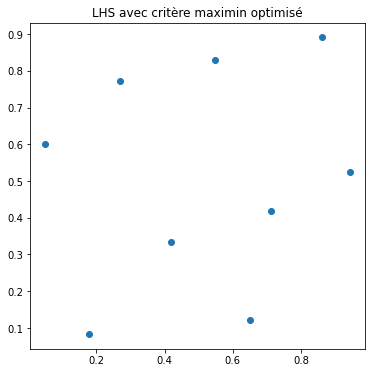

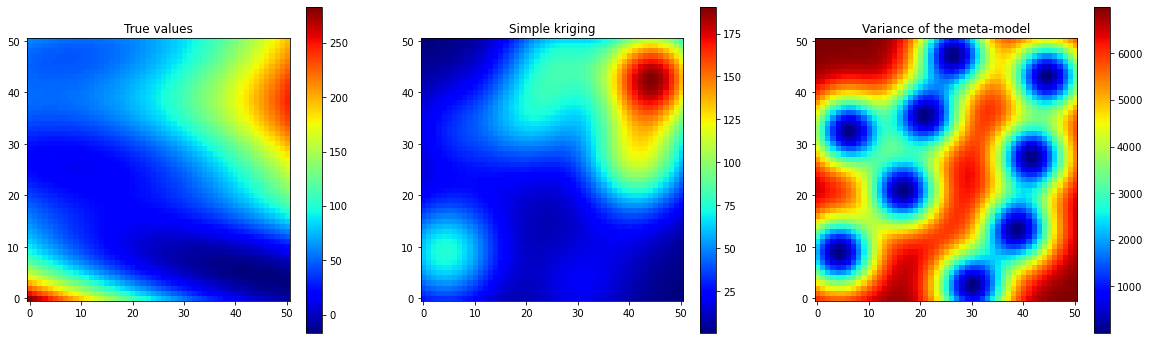

Erreur en norme L2 entre Z_true et Z: 1972.8710936494144


In [9]:
X_lhs = lhs(2,9,criterion="maximin",iterations=100)
y = y_func(X_lhs)
plt.figure(figsize=(6,6))
plt.scatter(X_lhs[:,0],X_lhs[:,1])
plt.title("LHS avec critère maximin optimisé")
plt.show()

n_test = 51
x_test = np.linspace(0,1,n_test)
X_test = np.array([[xi,xj] for xi in x_test for xj in x_test])
_,_,Z_true = eval_func(x_test,x_test,lambda x: fb(x))
Z = mn(X_test,X_lhs,y).reshape(n_test,n_test)
S = vn(X_test,X_lhs,y).reshape(n_test,n_test)
fig,(ax1,ax2,ax3) = plt.subplots(1,3)
fig.set_size_inches(20, 20)
pl1 = ax1.imshow(Z_true,cmap=cm.jet,origin="lower")
plt.colorbar(pl1,ax=ax1,shrink=0.3)
ax1.set_title("True values")
pl2 = ax2.imshow(Z,cmap=cm.jet,origin="lower")
plt.colorbar(pl2,ax=ax2,shrink=0.3)
ax2.set_title("Simple kriging")
pl3 = ax3.imshow(S,cmap=cm.jet,origin="lower")
plt.colorbar(pl3,ax=ax3,shrink=0.3)
ax3.set_title("Variance of the meta-model")
plt.show()


print(f"Erreur en norme L2 entre Z_true et Z: {LA.norm(Z_true-Z)}")

On a une erreur un peu moins grande avec le LHS qu'avec la grille uniforme.

θ_opt = 0.534902210495897


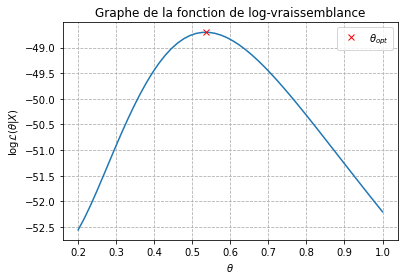

In [10]:
@np.vectorize
def ll(theta,X=X_lhs,y=y):
    """
    Fonction de log-vraissemblance log-L(θ|X)
    """
    n = len(X)
    sn = sigman2(X_lhs,y,lambda x1,x2: kg(x1,x2,theta=theta))
    Rn = r(X_lhs,X_lhs,lambda x1,x2: kg(x1,x2,theta=theta))
    return (-n/2*np.log(2*np.pi)-n/2*np.log(sn)-1/2*np.log(LA.det(Rn))-n/2)[0][0]
theta = np.linspace(0.2,1)
#On utilise BFGS (methode de gradient) parce que la fonction est concave que c'est ce qui a de plus efficace dans ce cas.
theta_opt = minimize(lambda t: -ll(t),0.2,method="BFGS").x
print(f"θ_opt = {theta_opt[0]}")
plt.plot(theta,ll(theta))
plt.plot(theta_opt,ll(theta_opt),"rx",label="$\\theta_{opt}$")
plt.title("Graphe de la fonction de log-vraissemblance")
plt.xlabel("$\\theta$")
plt.ylabel("$\log\mathcal{L}(\\theta|X)$")
plt.grid(ls="--")
plt.legend()
plt.show()

#### 3. EGO

In [11]:
def EI(x,X,y):
    """
    Fonction d'amélioration espérée (Expected improvement)
    E[max(fmin-Y,0)]
    """
    # theta_opt = minimize(lambda t: -ll(t),0.2,method="BFGS").x
    k_func = lambda x1,x2: kg(x1,x2,theta=theta_opt)
    ymin = np.min(y)
    mx = mn(x,X,y,k_func=k_func)
    sn = np.sqrt(vn(x,X,y,k_func=k_func)).T
    return (ymin-mx)*norm.cdf((ymin-mx)/sn)+sn*norm.pdf((ymin-mx)/sn)


    

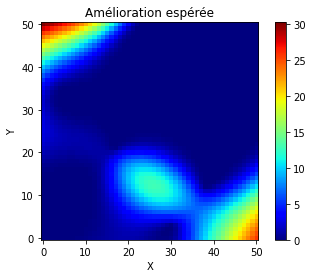

In [12]:
EI_res = EI(X_test,X_lhs,y_func(X_lhs)).reshape(n_test,n_test)
pl = plt.imshow(EI_res,cmap=cm.jet,origin="lower")
plt.title("Amélioration espérée")
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(pl)
plt.show()

On utilise BFGS comme optimiseur

In [13]:
def EGO_one_step(X,y,x0):
    # penalization function
    p = lambda x: 1000*(x[0]<0 or x[0]>1 or x[1]<0 or x[1]>1)
    J = lambda x: p(x)-EI(x,X,y)[0][0]
    # x = cma.fmin(J,[1/2,1/2],1/4)[0]
    x = minimize(J,np.random.rand(2,1),method="BFGS").x
    # x = muLambda(J,[1/2,1/2],0.25,2,10,0.1,nmax=5).best
    return x

def EGO_n_steps(X,x0,n=1):
    X_c = np.copy(X)
    y = y_func(X_c)
    for _ in range(n):
        x = EGO_one_step(X_c,y,x0)
        X_c = np.vstack([X_c,x])
        y = np.vstack([y,y_func(x.reshape(1,2))])
    return X_c,X_c[np.argmin(y)],np.min(y),len(X_c)

x0 = [1/2,1/2]
X2,x_opt,y_min,neval = EGO_n_steps(X_lhs,x0,11)


In [14]:
p = lambda x: 1000*(x[0]<0 or x[0]>1 or x[1]<0 or x[1]>1)
J = lambda x: p(x)+fb(x)
x_nelder = minimize(J,x0,method="Nelder-Mead",options={"maxiter":10,"return_all":True})
x_bfgs = minimize(J,x0,method="BFGS",options={"maxiter":5,"return_all":True})
print(x_opt,y_min,neval)
print(x_nelder.x,x_nelder.fun,x_nelder.nfev)
print(x_bfgs.x,x_bfgs.fun,x_bfgs.nfev)

[0.31810716 0.39857764] 18.364126338799196 20
[0.5015625 0.18125  ] 14.799644570908196 20
[0.50605523 0.18296545] 14.771944215634258 21


On voit que BFGS et Nelder-Mead sont à peu près équivalants et que notre algorithme EGO s'en sort un peu moins bien.
Cette remarque dépend bien sûr du choix du $x_0$.

#### 4. Propagation du feu de forêt

Optimisation avec la fonction pénalisée

In [41]:
# Cette partie est inspirée du tutoriel sur le site de Trieste: 
# https://secondmind-labs.github.io/trieste/notebooks/expected_improvement.html

space = trieste.space.Box([0,0,0.2,0.2],[1,1,1,1])

J = lambda t: tf.reshape(tf.map_fn(lambda x: fdf.cost_func(*x),t,parallel_iterations=4),[-1,1])
observer = trieste.objectives.utils.mk_observer(J)
num_initial = 9
doe = space.sample_sobol(num_initial)
initial_data = observer(doe)

def build_model(data):
    variance = tf.math.reduce_variance(data.observations)
    kernel = gpflow.kernels.SquaredExponential(variance=variance)
    gpr = gpflow.models.GPR(data.astuple(), kernel, noise_variance=1e-5)
    gpflow.set_trainable(gpr.likelihood, False)

    return GaussianProcessRegression(gpr, num_kernel_samples=100)


model = build_model(initial_data)

bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, space)

num_steps = 11
result = bo.optimize(num_steps, initial_data, model)
dataset = result.try_get_final_dataset()
query_points = dataset.query_points.numpy()
observations = dataset.observations.numpy()

arg_min_idx = tf.squeeze(tf.argmin(observations, axis=0))

print(f"query point: {query_points[arg_min_idx, :]}")
print(f"observation: {observations[arg_min_idx, :]}")

Optimization completed without errors
query point: [0.32762146 0.76808167 0.23319092 0.37210693]
observation: [2.35352829]


In [42]:
%matplotlib notebook
x_opt = query_points[arg_min_idx,:]
C,T = fdf.simu(*x_opt)
anim = fdf.anim2d(C,T)
anim.save("anim.mp4")
%matplotlib inline
Video("./anim.mp4")

<IPython.core.display.Javascript object>

Optimization avec la contrainte incluse dans la fonction d'acquisition

In [44]:

J2 = lambda t: tf.reshape(tf.map_fn(lambda x: fdf.cost_func_unpenalized(*x),t),[-1,1])
def contraint(x):
    xmin,xmax,ymin,ymax = x
    
    return np.float64(xmin>xmax or ymin>ymax)
C = lambda t: tf.reshape(tf.map_fn(contraint,t),[-1,1]) 
def observer(query_points):
    return {
        "OBJECTIVE":Dataset(query_points,J2(query_points)),
        "CONSTRAINT":Dataset(query_points,C(query_points))
    }

initial_data = observer(doe)
pof = trieste.acquisition.ProbabilityOfFeasibility(threshold=1/2)
eci = trieste.acquisition.ExpectedConstrainedImprovement(
    "OBJECTIVE", pof.using("CONSTRAINT")
)
rule = EfficientGlobalOptimization(eci) 

num_steps = 11
bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, space)


initial_models = trieste.utils.map_values(build_model, initial_data)


dataset = bo.optimize(
    num_steps, initial_data, initial_models, rule, track_state=False
).try_get_final_datasets()

dataset = dataset["OBJECTIVE"]

query_points = dataset.query_points.numpy()
observations = dataset.observations.numpy()

arg_min_idx = tf.squeeze(tf.argmin(observations, axis=0))

print(f"query point: {query_points[arg_min_idx, :]}")
print(f"observation: {observations[arg_min_idx, :]}")

Optimization completed without errors
query point: [0.46150454 0.8208378  0.2        0.56175541]
observation: [2.07281633]


In [45]:
%matplotlib notebook
x_opt = query_points[arg_min_idx,:]
C,T = fdf.simu(*x_opt)
anim = fdf.anim2d(C,T)
anim.save("anim.mp4")
%matplotlib inline
Video("./anim.mp4")

<IPython.core.display.Javascript object>

On a un résultat meilleur avec la deuxième approche.